# Download swath performance data

Download data.tar.gz from https://tiny.cc/ + the full manuscript ID for part 1 (case sensitive), and untar and ungzip this into the directory "MCS/mcs" and make sure the output folder is "data" and it has a folder named "track_data". Examine the code to see the proper location if you are getting an error (i.e., "../data/track_data/")

Max Diff (hrs): 1.69168050653 CRSR: 48 SSR: 96 MCS_Proba: 0.9
Min Diff (hrs): 0.909192022141 CRSR: 24 SSR: 48 MCS_Proba: 0.0
    CRSR  SSR  MCS_proba   ks_stat         p_val Significant
47     6   48       0.00  0.184357  1.404588e-50         YES
46    12   48       0.00  0.178077  7.337071e-59         YES
45    24   48       0.00  0.165432  1.536446e-64         YES
44    48   48       0.00  0.171573  2.216584e-83         YES
43     6   96       0.00  0.191056  1.387887e-49         YES
42    12   96       0.00  0.180184  5.382281e-56         YES
41    24   96       0.00  0.168985  3.883257e-63         YES
40    48   96       0.00  0.173515  6.577654e-80         YES
39     6  192       0.00  0.181681  1.285631e-42         YES
38    12  192       0.00  0.178444  1.242194e-52         YES
37    24  192       0.00  0.166647  1.816972e-59         YES
36    48  192       0.00  0.173979  1.591326e-78         YES
35     6   48       0.50  0.202529  1.110140e-25         YES
34    12   48       0

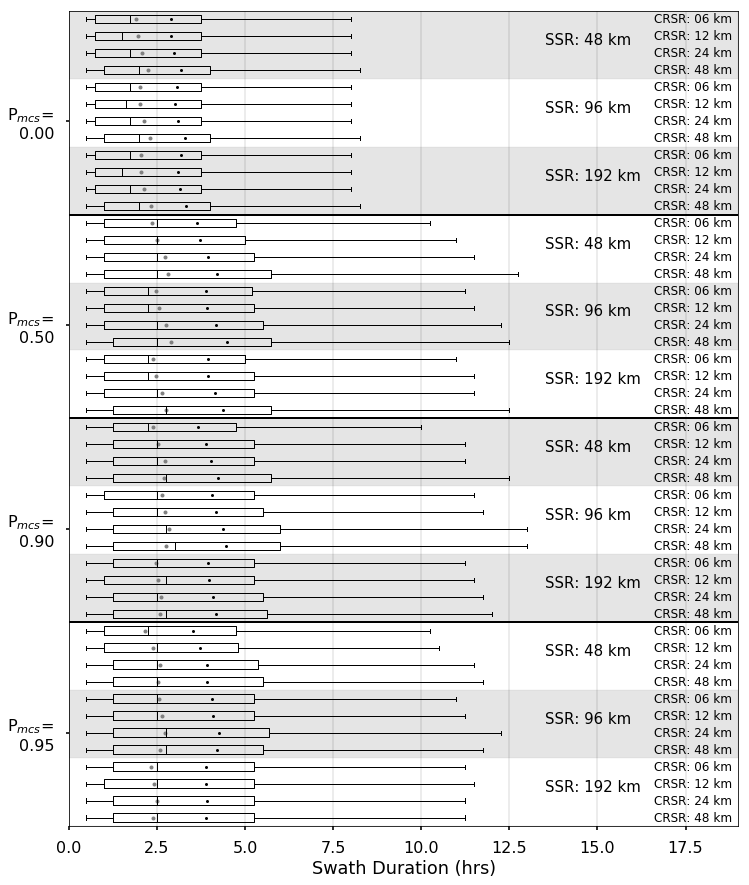

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from scipy.stats import ks_2samp

plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = 12,15

def draw_boxes(ax, data1, data2):
    
    meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

    bplot = ax.boxplot(data1, showmeans=True, meanprops=meanpointprops, vert=False)

    ax.plot(data2, range(1,49), '.', color='grey', markersize=8)

    plt.setp(bplot['medians'], color='black')

    [[item.set_color('black') for item in bplot['means']]]
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    return ax

def draw_labels(ax, ssr_x, crsr_x, xlab, df):
    for i in range(0, 51, 8):

        ax.axhspan((i-4)+.5, i+.5, color='k', alpha=0.1)

    ax.plot([-150, 150], [12.5, 12.5], color='k',linewidth=2)
    ax.plot([-150, 150], [24.5, 24.5], color='k',linewidth=2)
    ax.plot([-150, 150], [36.5, 36.5], color='k',linewidth=2)

    CRSR = df['CRSR'].values
    SSR = df['SSR'].values
    P = df['MCS_proba'].values

    for i in range(len(CRSR)):
        ax.annotate("CRSR: " +str(CRSR[i]).zfill(2) + " km",
                     xy=(crsr_x, i+.75), fontsize=12)

    SSR = [192, 96, 48] * 4

    for n, s in enumerate(SSR):

        plt.annotate("SSR: " + str(s) + " km", xy=(ssr_x, (n*4)+2.5), fontsize=15)

    locs = [6, 18, 30, 42]

    labs = ["P$_{mcs}$=\n" + l for l in ['0.95', '0.90', '0.50', '0.00']]
    
    ax.set_xlabel(xlab)
    ax.set_yticks(locs)
    ax.set_yticklabels(labs)
    ax.grid(which='major', linestyle='-', linewidth='0.15', color='black',zorder=0)
    plt.gca().yaxis.grid(False)   
    return ax

def load_data(year, var_name):
    
    dr = "../data/track_data/sum_stats/" + str(year) + "/" + str(year) + "_"

    df_un = pickle.load(open(dr + var_name + "_unmatched_master.pkl", 'rb'))
    df_re = pickle.load(open(dr + var_name + "_rematched_master.pkl", 'rb'))

    df_un = df_un.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=False)
    df_re = df_re.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=False)
    
    return df_un, df_re

def sig_diffs(unmatched, rematched):
    
    data1 = unmatched['Distribution'].values
    data2 = rematched['Distribution'].values
    
    crsr = rematched['CRSR'].values
    ssr = rematched['SSR'].values
    prob = rematched['MCS_proba'].values
    
    d = {'CRSR':[], 'SSR':[], 'MCS_proba':[], 'ks_stat':[], 'p_val':[], 'Significant': []}
    
    for idx, (x1, x2) in enumerate(zip(data1, data2)):
    
        ks_s, p = ks_2samp(x1, x2)

        d['CRSR'].append(crsr[idx])
        d['SSR'].append(ssr[idx])
        d['MCS_proba'].append(prob[idx])
        d['ks_stat'].append(ks_s)
        d['p_val'].append(p)
        
        if p < 0.001:
            d['Significant'].append("YES")
        if p >= 0.001:
            d['Significant'].append("--")
    
    return d

df_un, df_re = load_data(2015, 'mean_dur')

fig, ax = plt.subplots(1)

ax = draw_boxes(ax, df_re['Distribution'].values, df_un['mean'].values)

ax = draw_labels(ax, 13.5, 16.6, "Swath Duration (hrs)", df_re)

ax.set_xlim(0, 19)
ax.set_ylim(.5, 48.5)

max_diff = np.max(df_re['mean'].values - df_un['mean'].values)
min_diff = np.min(df_re['mean'].values - df_un['mean'].values)
max_loc = np.argmax(df_re['mean'].values - df_un['mean'].values)
min_loc = np.argmin(df_re['mean'].values - df_un['mean'].values)

print('Max Diff (hrs):', max_diff,
      'CRSR:', df_re['CRSR'].values[max_loc], 
      'SSR:', df_re['SSR'].values[max_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[max_loc])

print('Min Diff (hrs):', min_diff,
      'CRSR:', df_re['CRSR'].values[min_loc], 
      'SSR:', df_re['SSR'].values[min_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[min_loc])

sig_test = pd.DataFrame.from_dict(sig_diffs(df_un, df_re))
sig_test = sig_test.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=True)

print(sig_test[['CRSR', 'SSR', 'MCS_proba', 'ks_stat', 'p_val', 'Significant']])

Max Diff (hrs): 1.65915461796 CRSR: 24 SSR: 48 MCS_Proba: 0.95
Min Diff (hrs): 0.932125219162 CRSR: 6 SSR: 48 MCS_Proba: 0.0
    CRSR  SSR  MCS_proba   ks_stat         p_val Significant
47     6   48       0.00  0.181804  1.334652e-51         YES
46    12   48       0.00  0.183245  3.141849e-64         YES
45    24   48       0.00  0.174367  1.153082e-73         YES
44    48   48       0.00  0.177928  9.439442e-93         YES
43     6   96       0.00  0.189969  3.799047e-51         YES
42    12   96       0.00  0.184938  3.173125e-60         YES
41    24   96       0.00  0.175102  1.312222e-69         YES
40    48   96       0.00  0.182671  4.305834e-92         YES
39     6  192       0.00  0.194029  1.553600e-50         YES
38    12  192       0.00  0.184702  7.445389e-58         YES
37    24  192       0.00  0.175102  4.429525e-68         YES
36    48  192       0.00  0.186287  5.012759e-94         YES
35     6   48       0.50  0.198692  4.666628e-25         YES
34    12   48       0

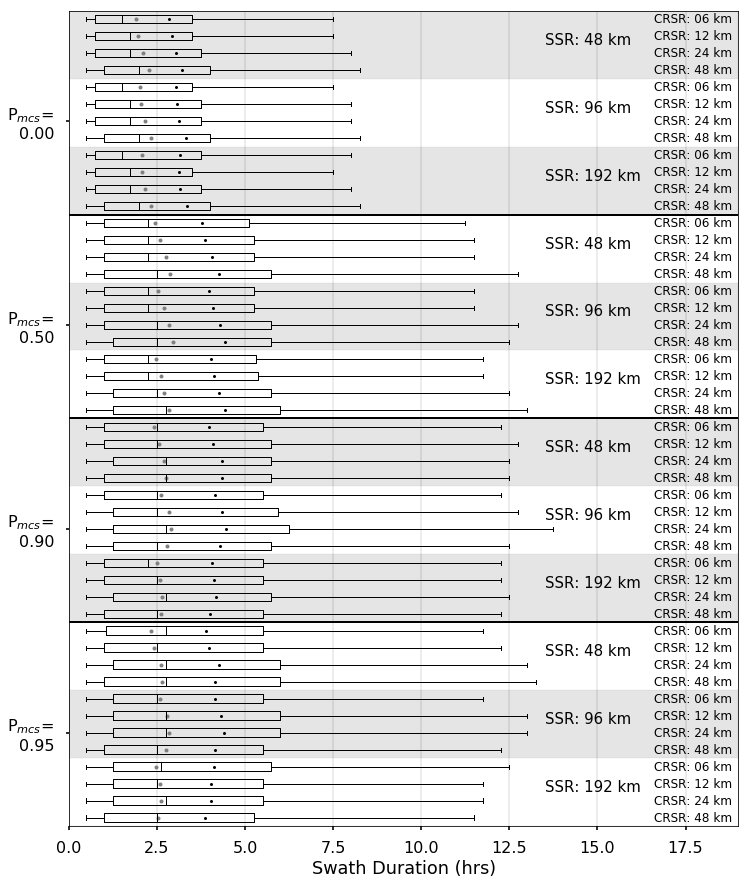

In [2]:
df_un, df_re = load_data(2016, 'mean_dur')

fig, ax = plt.subplots(1)

ax = draw_boxes(ax, df_re['Distribution'].values, df_un['mean'].values)

ax = draw_labels(ax, 13.5, 16.6, "Swath Duration (hrs)", df_re)

ax.set_xlim(0, 19)
ax.set_ylim(.5, 48.5)

max_diff = np.max(df_re['mean'].values - df_un['mean'].values)
min_diff = np.min(df_re['mean'].values - df_un['mean'].values)
max_loc = np.argmax(df_re['mean'].values - df_un['mean'].values)
min_loc = np.argmin(df_re['mean'].values - df_un['mean'].values)

print('Max Diff (hrs):', max_diff,
      'CRSR:', df_re['CRSR'].values[max_loc], 
      'SSR:', df_re['SSR'].values[max_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[max_loc])

print('Min Diff (hrs):', min_diff,
      'CRSR:', df_re['CRSR'].values[min_loc], 
      'SSR:', df_re['SSR'].values[min_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[min_loc])

sig_test = pd.DataFrame.from_dict(sig_diffs(df_un, df_re))
sig_test = sig_test.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=True)

print(sig_test[['CRSR', 'SSR', 'MCS_proba', 'ks_stat', 'p_val', 'Significant']])

Max Diff (hrs): 0.0636792535986 CRSR: 6 SSR: 192 MCS_Proba: 0.0
Min Diff (hrs): -0.037824220682 CRSR: 48 SSR: 192 MCS_Proba: 0.9
    CRSR  SSR  MCS_proba   ks_stat     p_val Significant
47     6   48       0.00  0.016246  0.933750          --
46    12   48       0.00  0.015691  0.889930          --
45    24   48       0.00  0.020127  0.462299          --
44    48   48       0.00  0.015089  0.687856          --
43     6   96       0.00  0.025909  0.508443          --
42    12   96       0.00  0.025499  0.383010          --
41    24   96       0.00  0.021205  0.437675          --
40    48   96       0.00  0.019202  0.421551          --
39     6  192       0.00  0.048182  0.024215          --
38    12  192       0.00  0.041056  0.033313          --
37    24  192       0.00  0.027224  0.181040          --
36    48  192       0.00  0.023814  0.194852          --
35     6   48       0.50  0.021782  0.972686          --
34    12   48       0.50  0.012882  0.999990          --
33    24   48   

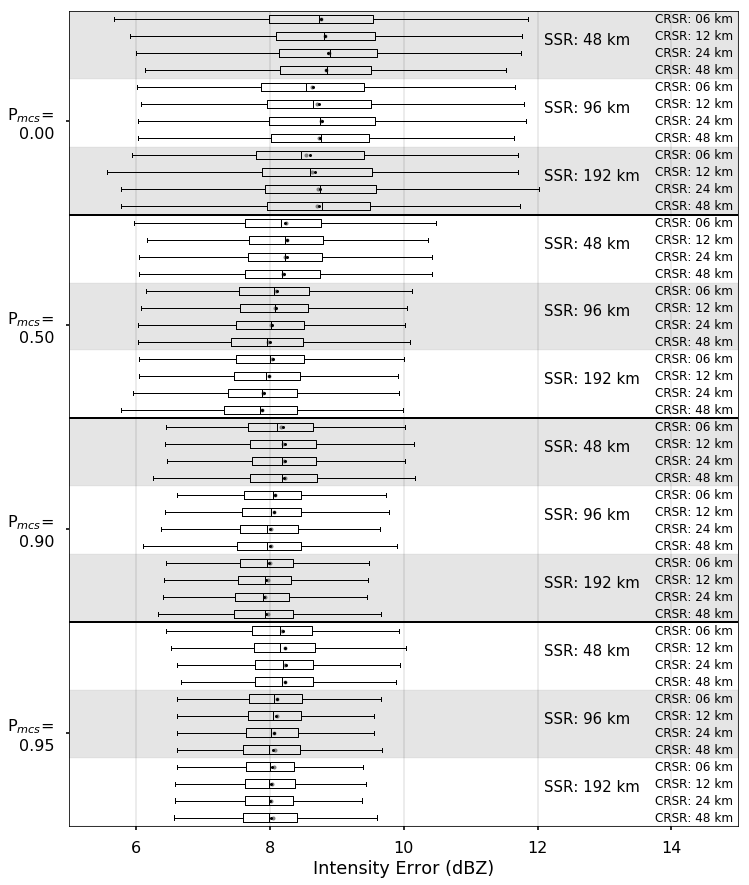

In [3]:
df_un, df_re = load_data(2015, 'std_refl')

fig, ax = plt.subplots(1)

ax = draw_boxes(ax, df_re['Distribution'].values, df_un['mean'].values)

ax = draw_labels(ax, 12.1, 13.75, "Intensity Error (dBZ)", df_re)

ax.set_xlim(5, 15)
ax.set_ylim(.5, 48.5)

max_diff = np.max(df_re['mean'].values - df_un['mean'].values)
min_diff = np.min(df_re['mean'].values - df_un['mean'].values)
max_loc = np.argmax(df_re['mean'].values - df_un['mean'].values)
min_loc = np.argmin(df_re['mean'].values - df_un['mean'].values)

print('Max Diff (hrs):', max_diff,
      'CRSR:', df_re['CRSR'].values[max_loc], 
      'SSR:', df_re['SSR'].values[max_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[max_loc])

print('Min Diff (hrs):', min_diff,
      'CRSR:', df_re['CRSR'].values[min_loc], 
      'SSR:', df_re['SSR'].values[min_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[min_loc])

sig_test = pd.DataFrame.from_dict(sig_diffs(df_un, df_re))
sig_test = sig_test.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=True)

print(sig_test[['CRSR', 'SSR', 'MCS_proba', 'ks_stat', 'p_val', 'Significant']])

Max Diff (hrs): 0.0473031947824 CRSR: 6 SSR: 192 MCS_Proba: 0.0
Min Diff (hrs): -0.0352306507284 CRSR: 48 SSR: 192 MCS_Proba: 0.95
    CRSR  SSR  MCS_proba   ks_stat     p_val Significant
47     6   48       0.00  0.024633  0.508427          --
46    12   48       0.00  0.022939  0.451361          --
45    24   48       0.00  0.016453  0.696379          --
44    48   48       0.00  0.013417  0.793448          --
43     6   96       0.00  0.035045  0.168885          --
42    12   96       0.00  0.032237  0.133171          --
41    24   96       0.00  0.016387  0.739784          --
40    48   96       0.00  0.013800  0.797808          --
39     6  192       0.00  0.041231  0.076438          --
38    12  192       0.00  0.033746  0.115835          --
37    24  192       0.00  0.020672  0.462569          --
36    48  192       0.00  0.017042  0.559153          --
35     6   48       0.50  0.027927  0.821178          --
34    12   48       0.50  0.023050  0.928292          --
33    24   48 

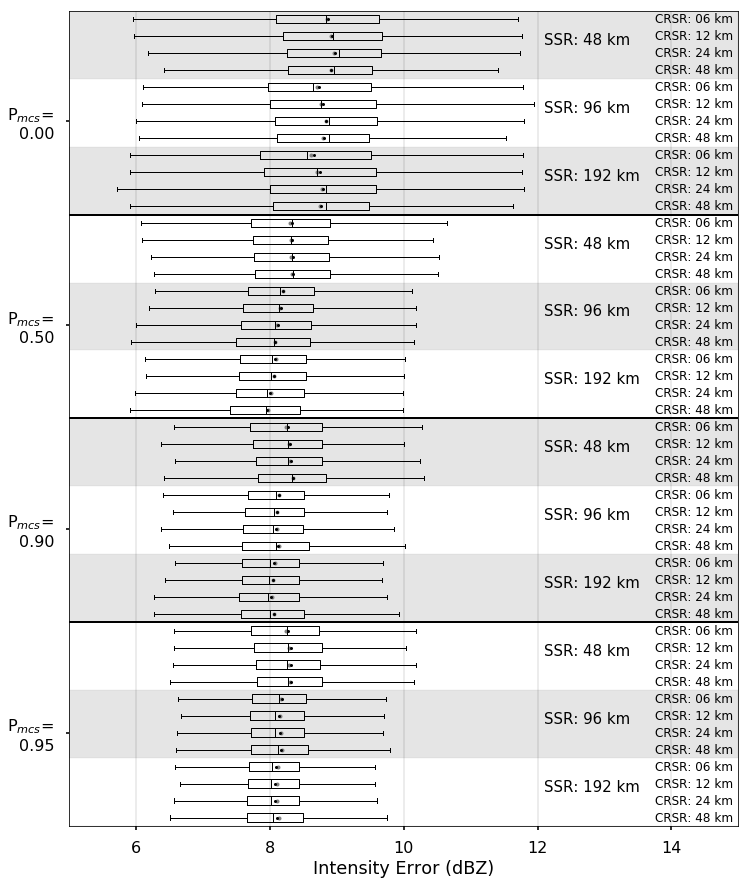

In [4]:
df_un, df_re = load_data(2016, 'std_refl')

fig, ax = plt.subplots(1)

ax = draw_boxes(ax, df_re['Distribution'].values, df_un['mean'].values)

ax = draw_labels(ax, 12.1, 13.75, "Intensity Error (dBZ)", df_re)

ax.set_xlim(5, 15)
ax.set_ylim(.5, 48.5)

max_diff = np.max(df_re['mean'].values - df_un['mean'].values)
min_diff = np.min(df_re['mean'].values - df_un['mean'].values)
max_loc = np.argmax(df_re['mean'].values - df_un['mean'].values)
min_loc = np.argmin(df_re['mean'].values - df_un['mean'].values)

print('Max Diff (hrs):', max_diff,
      'CRSR:', df_re['CRSR'].values[max_loc], 
      'SSR:', df_re['SSR'].values[max_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[max_loc])

print('Min Diff (hrs):', min_diff,
      'CRSR:', df_re['CRSR'].values[min_loc], 
      'SSR:', df_re['SSR'].values[min_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[min_loc])

sig_test = pd.DataFrame.from_dict(sig_diffs(df_un, df_re))
sig_test = sig_test.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=True)

print(sig_test[['CRSR', 'SSR', 'MCS_proba', 'ks_stat', 'p_val', 'Significant']])

Max Diff (hrs): 6.84185265466 CRSR: 48 SSR: 192 MCS_Proba: 0.95
Min Diff (hrs): 2.99178234102 CRSR: 48 SSR: 48 MCS_Proba: 0.0
    CRSR  SSR  MCS_proba   ks_stat     p_val Significant
47     6   48       0.00  0.068710  0.000062         YES
46    12   48       0.00  0.070969  0.000002         YES
45    24   48       0.00  0.063366  0.000001         YES
44    48   48       0.00  0.051501  0.000014         YES
43     6   96       0.00  0.070098  0.000101         YES
42    12   96       0.00  0.070087  0.000008         YES
41    24   96       0.00  0.060557  0.000009         YES
40    48   96       0.00  0.054699  0.000007         YES
39     6  192       0.00  0.060492  0.001903          --
38    12  192       0.00  0.070827  0.000010         YES
37    24  192       0.00  0.060680  0.000013         YES
36    48  192       0.00  0.054976  0.000008         YES
35     6   48       0.50  0.094060  0.000309         YES
34    12   48       0.50  0.081044  0.001556          --
33    24   48      

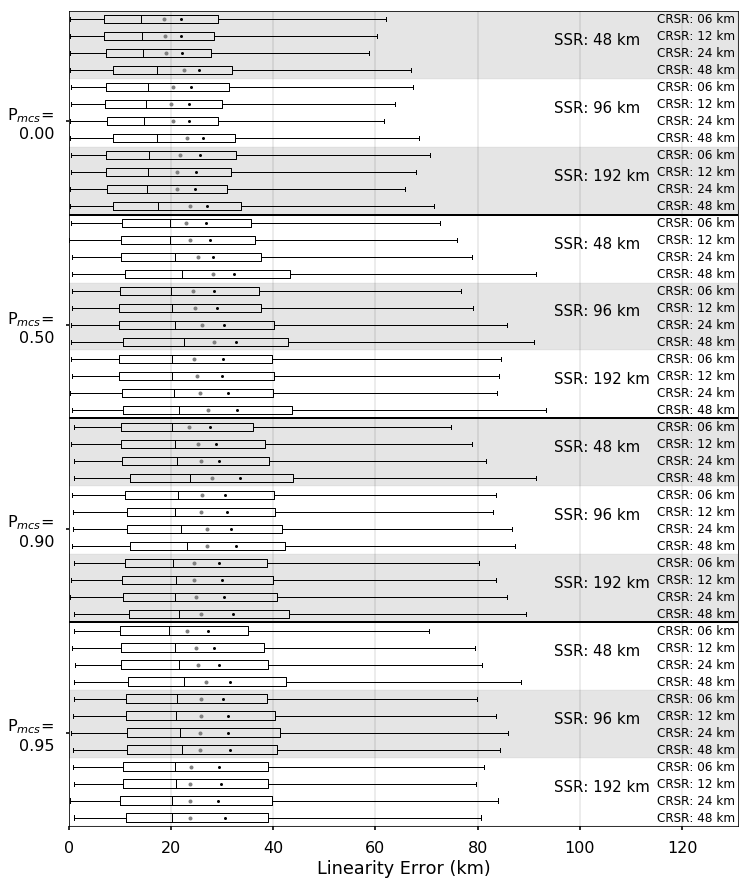

In [5]:
df_un, df_re = load_data(2015, 'lin_err')

fig, ax = plt.subplots(1)

ax = draw_boxes(ax, df_re['Distribution'].values, df_un['mean'].values)

ax = draw_labels(ax, 95, 115, "Linearity Error (km)", df_re)

ax.set_xlim(0, 131)
ax.set_ylim(.5, 48.5)

max_diff = np.max(df_re['mean'].values - df_un['mean'].values)
min_diff = np.min(df_re['mean'].values - df_un['mean'].values)
max_loc = np.argmax(df_re['mean'].values - df_un['mean'].values)
min_loc = np.argmin(df_re['mean'].values - df_un['mean'].values)

print('Max Diff (hrs):', max_diff,
      'CRSR:', df_re['CRSR'].values[max_loc], 
      'SSR:', df_re['SSR'].values[max_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[max_loc])

print('Min Diff (hrs):', min_diff,
      'CRSR:', df_re['CRSR'].values[min_loc], 
      'SSR:', df_re['SSR'].values[min_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[min_loc])

sig_test = pd.DataFrame.from_dict(sig_diffs(df_un, df_re))
sig_test = sig_test.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=True)

print(sig_test[['CRSR', 'SSR', 'MCS_proba', 'ks_stat', 'p_val', 'Significant']])

Max Diff (hrs): 6.17534253831 CRSR: 48 SSR: 48 MCS_Proba: 0.9
Min Diff (hrs): 2.44075534771 CRSR: 48 SSR: 96 MCS_Proba: 0.0
    CRSR  SSR  MCS_proba   ks_stat         p_val Significant
47     6   48       0.00  0.065254  1.513812e-04         YES
46    12   48       0.00  0.073534  5.138043e-07         YES
45    24   48       0.00  0.064649  3.641846e-07         YES
44    48   48       0.00  0.051597  7.747679e-06         YES
43     6   96       0.00  0.066308  2.877902e-04         YES
42    12   96       0.00  0.066633  1.881806e-05         YES
41    24   96       0.00  0.066016  5.377164e-07         YES
40    48   96       0.00  0.047282  1.102714e-04         YES
39     6  192       0.00  0.072504  8.261662e-05         YES
38    12  192       0.00  0.071454  5.682505e-06         YES
37    24  192       0.00  0.072207  4.087830e-08         YES
36    48  192       0.00  0.050973  2.762061e-05         YES
35     6   48       0.50  0.080880  2.528464e-03          --
34    12   48       0.

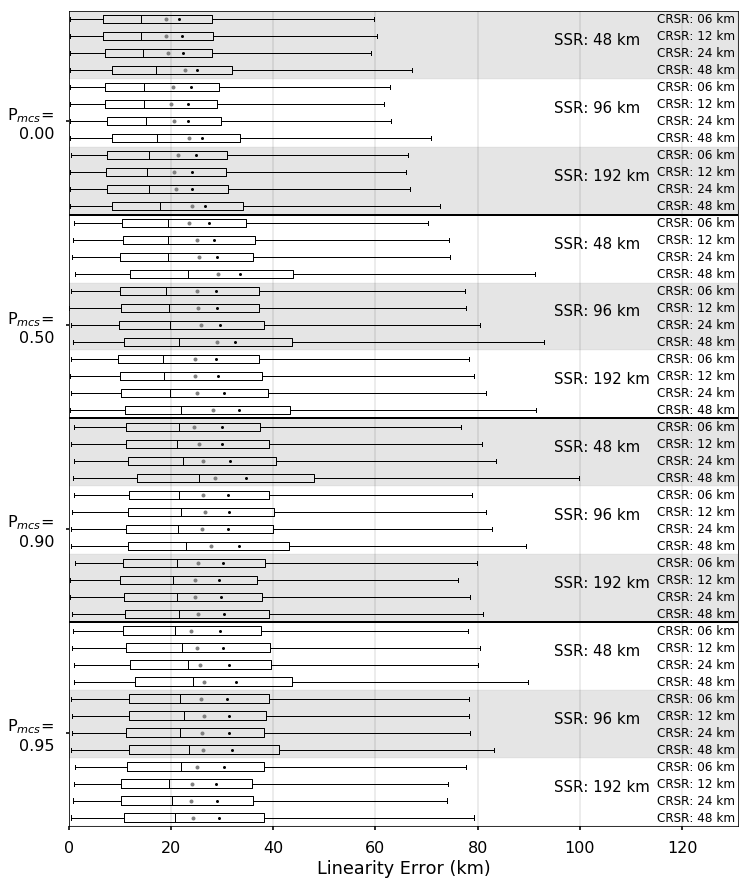

In [6]:
df_un, df_re = load_data(2016, 'lin_err')

fig, ax = plt.subplots(1)

ax = draw_boxes(ax, df_re['Distribution'].values, df_un['mean'].values)

ax = draw_labels(ax, 95, 115, "Linearity Error (km)", df_re)

ax.set_xlim(0, 131)
ax.set_ylim(.5, 48.5)

max_diff = np.max(df_re['mean'].values - df_un['mean'].values)
min_diff = np.min(df_re['mean'].values - df_un['mean'].values)
max_loc = np.argmax(df_re['mean'].values - df_un['mean'].values)
min_loc = np.argmin(df_re['mean'].values - df_un['mean'].values)

print('Max Diff (hrs):', max_diff,
      'CRSR:', df_re['CRSR'].values[max_loc], 
      'SSR:', df_re['SSR'].values[max_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[max_loc])

print('Min Diff (hrs):', min_diff,
      'CRSR:', df_re['CRSR'].values[min_loc], 
      'SSR:', df_re['SSR'].values[min_loc],
      'MCS_Proba:', df_re['MCS_proba'].values[min_loc])

sig_test = pd.DataFrame.from_dict(sig_diffs(df_un, df_re))
sig_test = sig_test.sort_values(by=['MCS_proba', 'SSR', 'CRSR'], ascending=True)

print(sig_test[['CRSR', 'SSR', 'MCS_proba', 'ks_stat', 'p_val', 'Significant']])

(0.5, 48.5)

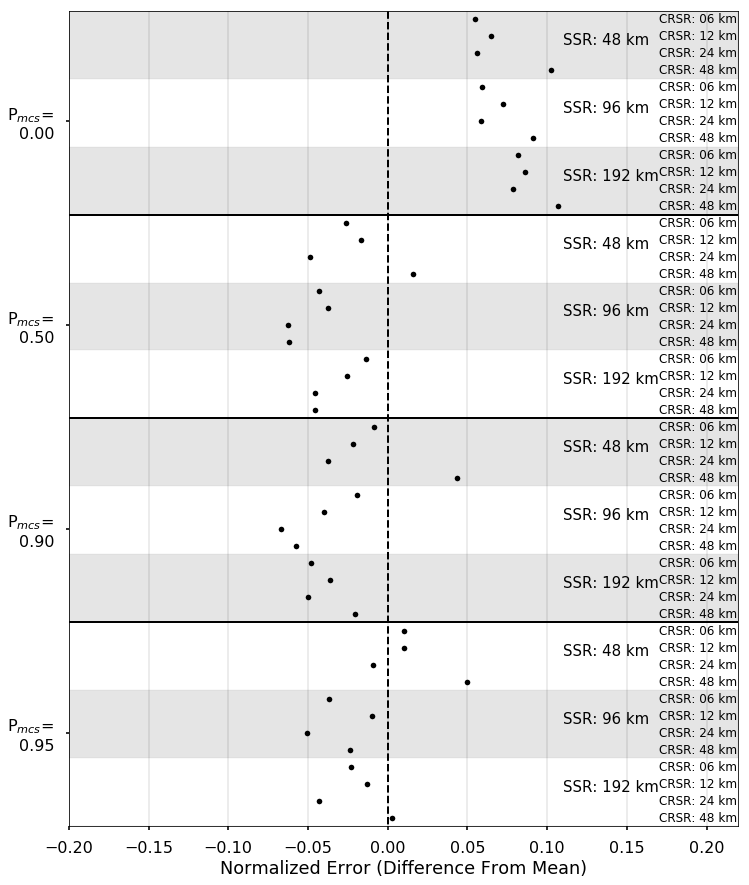

In [7]:
def get_normalized(df1, df2, df3):
    
    data1 = df1['mean'].values
    data2 = df2['mean'].values
    data3 = df3['mean'].values
    
    return ((data1/np.max(data1))+(data2/np.max(data2))-(data3/np.max(data3)))

_, df_dur = load_data(2015, 'mean_dur')
_, df_std = load_data(2015, 'std_refl')
_, df_lin = load_data(2015, 'lin_err')

vals = get_normalized(df_std, df_lin, df_dur)

fig, ax = plt.subplots(1)

ax.plot(vals - np.mean(vals), list(range(1,49)), 'k.')

ax = draw_labels(ax, .11, .17, "Normalized Error (Difference From Mean)", df_dur)

plt.plot([0, 0], [0, 50], 'k--',linewidth=2)
ax.set_xlim(-.2, .22)
ax.set_ylim(.5, 48.5)

(0.5, 48.5)

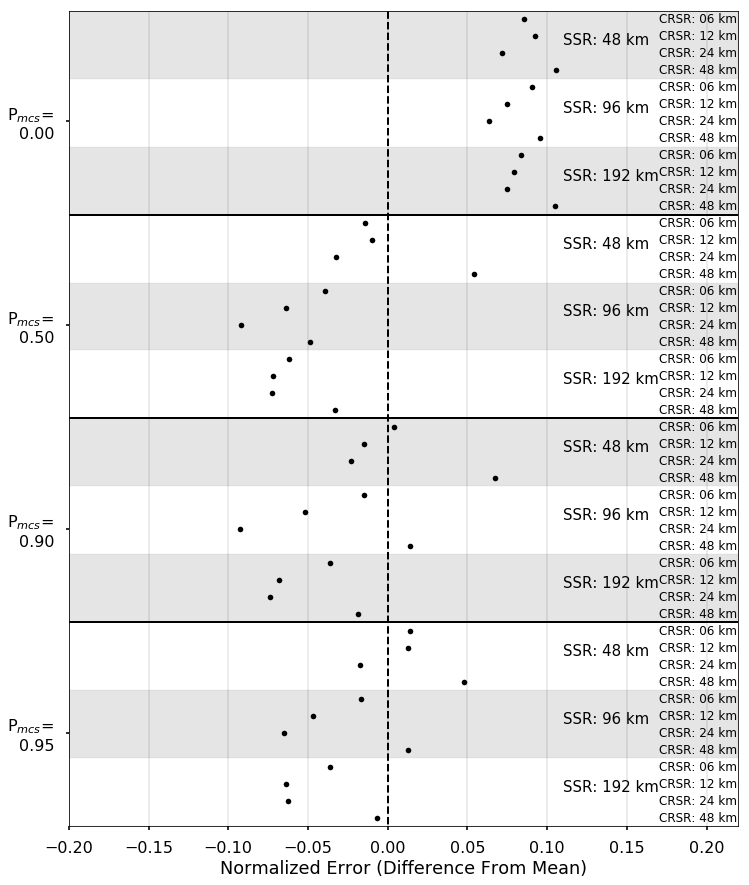

In [8]:
_, df_dur = load_data(2016, 'mean_dur')
_, df_std = load_data(2016, 'std_refl')
_, df_lin = load_data(2016, 'lin_err')

vals = get_normalized(df_std, df_lin, df_dur)

fig, ax = plt.subplots(1)

ax.plot(vals - np.mean(vals), list(range(1,49)), 'k.')

ax = draw_labels(ax, .11, .17, "Normalized Error (Difference From Mean)", df_dur)

plt.plot([0, 0], [0, 50], 'k--',linewidth=2)
ax.set_xlim(-.2, .22)
ax.set_ylim(.5, 48.5)